<font size="5"><p style="text-align:center"><b> Мобильные приложения — Выделение групп пользователей на основе поведения </b></p></font>

**Презентация:** https://disk.yandex.ru/i/AWPf3npEa8VJ0A

**Описание данных:**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Данные представлены двумя датасетами:
- **mobile_dataset.csv** - названия событий и время их совершения
- **mobile_sources.csv** - источник, с которого пользователь установил приложение\
Датасеты связаны по id пользователей

**Цель исследования:**
- Выделение целевой и нецелевой аудитории
    (Выделить сегменты пользователей для управления вовлеченностью (адаптировать приложение под целевую и смежные аудитории))
- Проверка гипотез
    (получить на основе сегментации, гипотезы о том как можно было бы улучшить приложение с точки зрения пользовательского опыта)

**Ход исследования:**
1. Обзор данных.
2. Предобработка данных.
  - приведение столбцов к единому виду
  - преобразование типов данных
  - проверка и обработка дубликатов
  - проверка и обработка пропусков
  - выявление аномалий
3. Исследовательский анализ
- Анализ пользователей по метрикам:
    - retention rate,
    - время, проведённое в приложении, 
    - частота действий, 
    - конверсия в целевое действие — просмотр контактов
4. Сегментирование пользователей
- пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)
- пользователи какой группы часто делают целевое событие (конверсия в целевое действие)
5. Проверка гипотез:
- Гипотеза о конверсии в зависимости от источника
- Гипотеза о конверсии в зависимости от добавления в избранное
6. Общий вывод

## Загрузка и обзор данных

### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mth
from datetime import datetime, timedelta

### Загрузка данных

In [2]:
source = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
event = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
event.sample(5)

,event.time,event.name,user.id
56334,2019-10-28 15:16:01.660063,map,a47383fb-ced7-425c-a203-5ecec7dfb31e
2825,2019-10-08 10:40:07.011397,search_1,a0c40e0f-8fc1-41ac-95e3-38006d251009
53498,2019-10-27 16:53:38.520799,map,448b0a18-cc38-44fa-b0e3-50d1cafe7470
8530,2019-10-10 16:14:08.516920,tips_show,ed52ecb0-1839-49bc-ab90-1bf7872e4ca8
68618,2019-11-01 18:10:15.901886,tips_show,9f210a87-9b74-4e73-8c28-32b40dd3401e


**event.time** — время совершения\
**event.name** — название события\
**user.id** — идентификатор пользователя

**Расшифровки событий:**

**advert_open** — открытие карточки объявления\
**photos_show** — просмотр фотографий в объявлении\
**tips_show** — пользователь увидел рекомендованные объявления\
**tips_click** — пользователь кликнул по рекомендованному объявлению\
**contacts_show и show_contacts** — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления\
**contacts_call** — пользователь позвонил по номеру телефона на карточке объявления\
**map** — пользователь открыл карту размещенных объявлений\
**search_1 — search_7** — разные события, связанные с поиском по сайту\
**favorites_add** — добавление объявления в избранное

In [4]:
source.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


**userId** — идентификатор пользователя\
**source** — источник, с которого пользователь установил приложение

### Общая информация о данных

In [5]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
print('Строк в датасете',event.shape[0])

Строк в датасете 74197


In [7]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [8]:
print('Строк в датасете',source.shape[0])

Строк в датасете 4293


In [9]:
print('Уникальных пользователей', source['userId'].nunique())

Уникальных пользователей 4293


За имеющийся период 4 293 уникальных пользователя совершили 74 197 событий

## Предобработка данных

### Приведение столбцов к единому виду

Названия колонок написаны через точку либо слитно. Приведем их к более удобному и общепринятому написанию через нижнее подчеркивание

In [10]:
event.columns = [x.replace('.', '_') for x in event.columns.values]

In [11]:
event.head(2)

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894


In [12]:
source = source.rename(columns={'userId' : 'user_id'})

In [13]:
source.head(2)

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


### Преобразование типов данных

Формат object не позволит нам анализировать даты, поэтому приведем значения к специальному формату для даты и времени

In [14]:
# преобразуем object дату в формат datetime
event['event_time'] = pd.to_datetime(event['event_time'])

In [15]:
# создадим отдельный столюец с датой
event['date'] = event['event_time'].dt.date
# отдельный столбец с днем недели для анализа
event['event_weekday'] = event['event_time'].dt.weekday # номер дня недели от 0 (понеделник) до 6 (воскресенье) для даты

In [16]:
event.head()

,event_time,event_name,user_id,date,event_weekday
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0


По ТЗ в датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.
Проверим минимальную и максимальную даты

In [17]:
print('Минимальная дата в датасете', event.date.min())
print('Максимальная дата в датасете', event.date.max())
print('Данные за', event.date.max()-event.date.min(), 'дней')

Минимальная дата в датасете 2019-10-07
Максимальная дата в датасете 2019-11-03
Данные за 27 days, 0:00:00 дней


Типы данных приведены. Даты соответствуют ТЗ.\
В нашем распоряжении данные за 27 дней - с 7.10.2019 по 3.11.2019

### Проверка и обработка дубликатов

#### Таблица событий

In [18]:
event.head(3)

,event_time,event_name,user_id,date,event_weekday
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0


In [19]:
print('Полных дубликатов в таблице событий',event.duplicated().sum())

Полных дубликатов в таблице событий 0


In [20]:
print(event.event_name.unique())
print('Названий событий', event.event_name.nunique())

['advert_open' 'tips_show' 'map' 'contacts_show' 'search_4' 'search_5'
 'tips_click' 'photos_show' 'search_1' 'search_2' 'search_3'
 'favorites_add' 'contacts_call' 'search_6' 'search_7' 'show_contacts']
Названий событий 16


Из задания мы знаем, что contacts_show и show_contacts одно и то же действие. Приведем к одному виду

In [21]:
event['event_name'] = event['event_name'].replace('contacts_show', 'show_contacts')

In [22]:
print('Названий событий', event.event_name.nunique())

Названий событий 15


Т.к. нам не известно, какие именно поиски скрываются за search_1 — search_7, для сокращения переменных в исследовании объединим их в один search

In [23]:
event.loc[event['event_name'].str.contains('search'), 'event_name'] = 'search'

In [24]:
print(event.event_name.unique())
print('Названий событий', event.event_name.nunique())

['advert_open' 'tips_show' 'map' 'show_contacts' 'search' 'tips_click'
 'photos_show' 'favorites_add' 'contacts_call']
Названий событий 9


Получили 9 уникальных названий событий, которые могли совершить пользователи

#### Таблица пользователей

In [25]:
source.sample(3)

,user_id,source
2086,b5567588-6d04-441d-9f19-dac24f8bff01,yandex
1689,179ce92d-e847-4302-ac3b-8cc38e5e7d07,yandex
518,5767e207-b281-4f68-84c4-94f1fe1dfeb4,other


Мы уже проверили таблицу на уникальность id пользователей и увидели совпадение кол-ва строк с кол-вом id. Значит полных дубликатов у нас нет. Но на случай изменений исходных данных добавим проверку польных дубликатов

In [26]:
print('Полных дубликатов в табице пользователей',source.duplicated().sum())

Полных дубликатов в табице пользователей 0


<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

    
Проверка на дубликаты - основа предобработки данных

In [27]:
source.source.unique()

array(['other', 'yandex', 'google'], dtype=object)

Источника данных всего 3: Яндекс, Гугл и другие

Чтобы не работать по отдельности с таблицами и иметь полные данные в одном месте, объединим таблицы по id пользователей

In [28]:
data = event.merge(source, on='user_id', how = 'left')

Прверяем правильность объединения

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event_time     74197 non-null  datetime64[ns]
 1   event_name     74197 non-null  object        
 2   user_id        74197 non-null  object        
 3   date           74197 non-null  object        
 4   event_weekday  74197 non-null  int64         
 5   source         74197 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.0+ MB


In [30]:
data.user_id.nunique()

4293

Ни одного события не потерялось и все уникальные пользователи на месте

In [31]:
data.sample(4)

,event_time,event_name,user_id,date,event_weekday,source
52321,2019-10-27 08:09:46.427806,photos_show,70160b67-0a2a-4ed5-8030-8f3c081d2d10,2019-10-27,6,google
65661,2019-10-31 16:36:15.601139,photos_show,4d7a30ab-238a-40db-8a39-45bebfd694ce,2019-10-31,3,yandex
21521,2019-10-15 23:10:34.906091,advert_open,0d5c7fc6-7a74-4a7d-a7f6-f19a739365f6,2019-10-15,1,yandex
17195,2019-10-14 14:56:22.569726,tips_show,06fd2e8a-0270-4749-9abc-e215a2318bfa,2019-10-14,0,google


### Проверка и обработка пропусков

In [32]:
print('Кол-во пропусков в таблице: \n', data.isna().sum()) 

Кол-во пропусков в таблице: 
 event_time       0
event_name       0
user_id          0
date             0
event_weekday    0
source           0
dtype: int64


Пропусков в наших таблицах нет, данные собраны корректно

### Проверка аномалий

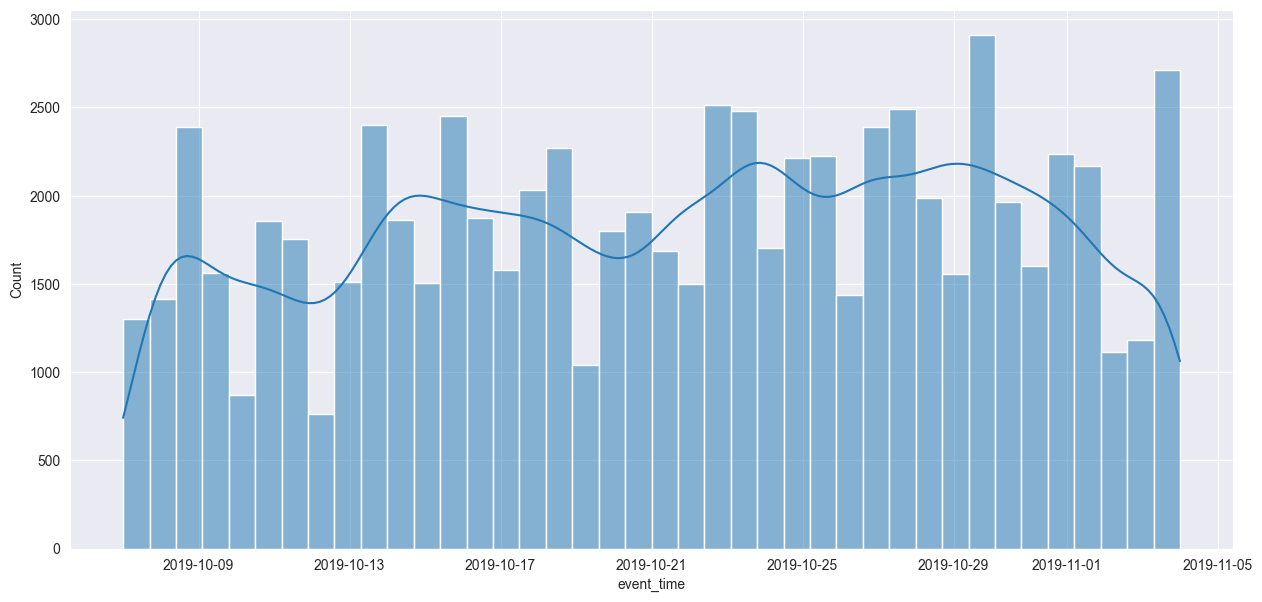

In [33]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,7))
sns.histplot(x='event_time', data=data, kde=True, bins=40);

In [34]:
dates_of_event = event.groupby('date')[['event_name']].count().reset_index()
dates_of_event.head()

,date,event_name
0,2019-10-07,2545
1,2019-10-08,2499
2,2019-10-09,2027
3,2019-10-10,2243
4,2019-10-11,2030


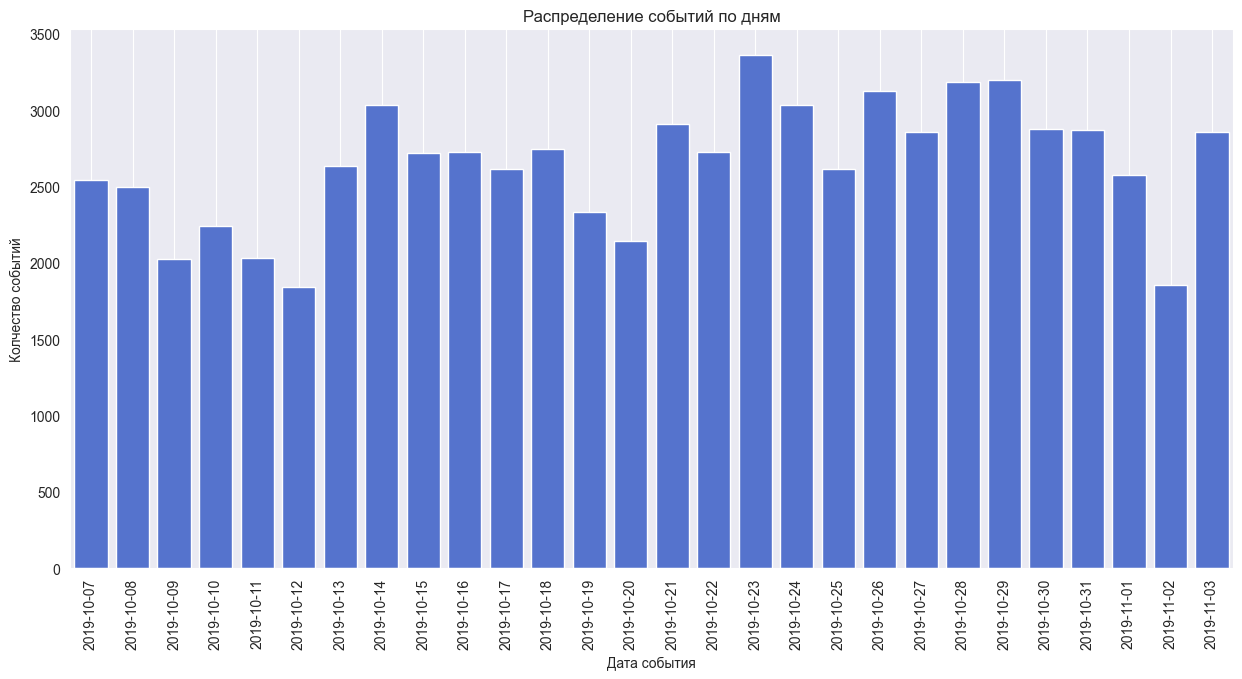

In [35]:
plt.figure(figsize = (15,7))
sns.barplot(x='date', y='event_name', data=dates_of_event, color = 'royalblue')
plt.xticks(rotation=90)
plt.xlabel('Дата события')
plt.ylabel('Колчество событий')
plt.grid()
plt.title('Распределение событий по дням')
plt.show()

События распределены приблизительно равномерно по всему временному промежутку доступных данных. Сбоев в работе приложения не было. Поэтому нет необходимости исключать какие-либо даты. Будем анализировать весь период

### Подготовка данных. Выделение сессий

Для дальнейшего анализа нам полезно посмотреть на взаимодействие пользователей в разрезе сессий. К сожалению в наши данные не записывается принадлежность к сессии. Выделим их самостоятельно. К одной сессии отнесем все те события, между которыми прошло менее 30 минут. 

30 минут достаточно, чтобы оценить объявление проверить характеристики на другом сайте или посмотреть обзор на товар.Так же врят ли можно отнести к следующнй сессии события, если пользователи отошел на перекур или налить чай и потом снова продолжил искать нужные вещи. Если перерыв более 30 минут - более вероянтно, что пользователь полноценно переключился на другое дело.

In [36]:
data = data.sort_values(['user_id', 'event_time'])
data.head(10)

,event_time,event_name,user_id,date,event_weekday,source
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2,other


In [37]:
# Если между действиями большн 30 минут принимаем это за новую сессию
diff_timestamp = data.groupby('user_id')['event_time'].diff()
new_session = (diff_timestamp.isnull()) | (diff_timestamp.dt.total_seconds() > 1800)
data['session_id'] = data.loc[new_session == True, ['user_id', 'event_time']].groupby('user_id').rank(method='first').astype(int)
data['session_id'] = data['session_id'].fillna(method='ffill').astype(int)

In [38]:
data.head(15)

,event_time,event_name,user_id,date,event_weekday,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2,other,2


In [39]:
# добавляем начало и конец каждой сессии, а так же кол-во событий внутри сессии
sessions = data.groupby(['user_id', 'session_id']).agg({'source': 'first' ,'event_time':['first', 'last'], 
                                                   'event_name':'count'}).reset_index()
sessions = sessions.set_axis(['user_id', 'session_id', 'source' ,'session_start', 'session_end', 'events_count'], axis='columns')

In [40]:
sessions.head()

,user_id,session_id,source,session_start,session_end,events_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,4
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,14
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,8
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,9


Получили таблицу с id пользователя, номером сессии началом, концом сессии и кол-вом событий в ней. Теперь посчитаем длительность каждой сессии.

In [41]:
sessions['duration'] = sessions['session_end']-sessions['session_start']

In [42]:
sessions.head()

,user_id,session_id,source,session_start,session_end,events_count,duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9,0 days 00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,4,0 days 00:08:27.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,14,0 days 00:14:59.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,8,0 days 00:12:38.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,9,0 days 00:25:20.787329


### Вывод по разделу предобработки

В нашем распоряжении данные за **27 дней** - с 7.10.2019 по 3.11.2019\
За имеющийся период **4 293** уникальных пользователя совершили **74 197** событий\
Пропусков и полных дубликатов в данных нет, все собрано корректно

**На этапе предобработки:**

- Преобразовали даты к формату даты и времени, для возможности дальнейшего анализа
- Устранили неявные дубликаты с различным написанием событий пользователей
- Проверили распределение событий по дням - распределение приблизительно равномерное по всему временному промежутку доступных данных. Сбоев в работе приложения не было. Поэтому нет необходимости исключать какие-либо даты. Будем анализировать весь период
- Дополнительно сделали разбитие на 30 минутные сессии действий пользователей

## Исследовательский анализ

### Анализ пользователей по частота действий

#### Кол-во сессий пользователей

Посмотрим, сколько сессий приходится на каждого пользователя

In [43]:
session_count = sessions.groupby('user_id').agg({'session_id': 'last'}).reset_index().groupby('session_id')['user_id'].count().reset_index()
session_count.columns = ['count_session', 'count_user']
session_count.head(10)

,count_session,count_user
0,1,2300
1,2,878
2,3,462
3,4,239
4,5,109
5,6,77
6,7,55
7,8,32
8,9,23
9,10,9


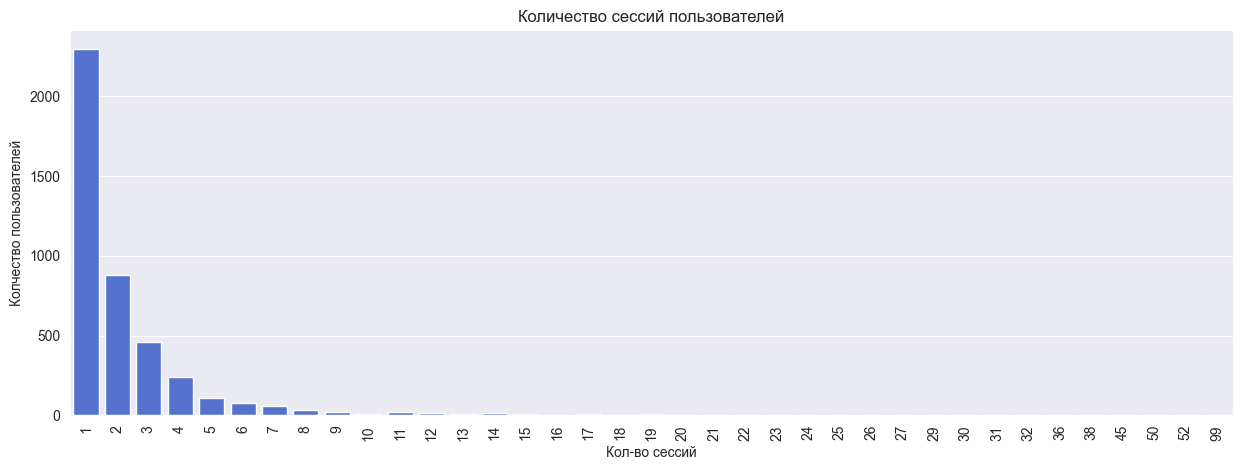

In [45]:
plt.figure(figsize = (15,5))
sns.barplot(x='count_session', y='count_user', data=session_count, color = 'royalblue')
plt.xticks(rotation=90)
plt.xlabel('Кол-во сессий')
plt.ylabel('Колчество пользователей')
#plt.grid()
plt.title('Количество сессий пользователей')
plt.show()

Чаще всего пользователи совершили не более 3 сессий. Очень большой процент пользвателей ограничились одной сессией

In [46]:
session_count.describe()

,count_session,count_user
count,37.000000,37.000000
mean,22.162162,116.027027
std,18.448899,403.350997
min,1.000000,1.000000
25%,10.000000,1.000000
50%,19.000000,3.000000
75%,29.000000,22.000000
max,99.000000,2300.000000


#### Сколько действий в среднем совершают наши пользователи за весь имеющийся период

In [47]:
event_per_user = data.groupby('user_id')['event_time'].count().reset_index()
event_per_user.columns = ['user_id', 'count_event']
event_per_user.sort_values(by='count_event', ascending=False).head(5)
event_per_user.describe(percentiles=[0.1, 0.25, 0.5, 0.95, 0.99])

,count_event
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
10%,4.000000
25%,5.000000
50%,9.000000
95%,59.000000
99%,132.000000
max,478.000000


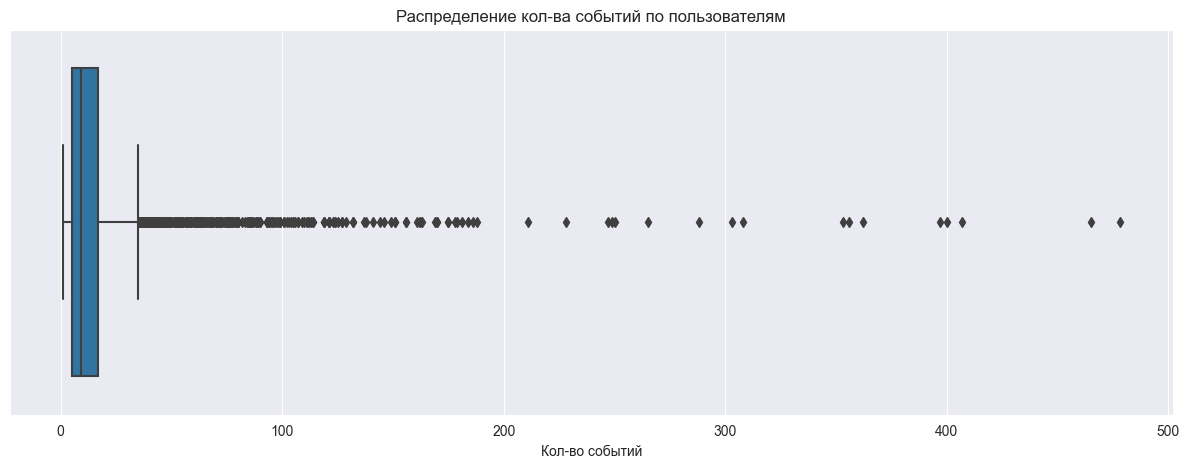

In [48]:
plt.figure(figsize = (15,5))
sns.boxplot(x='count_event', data=event_per_user)
plt.title('Распределение кол-ва событий по пользователям')
plt.xlabel("Кол-во событий"); 

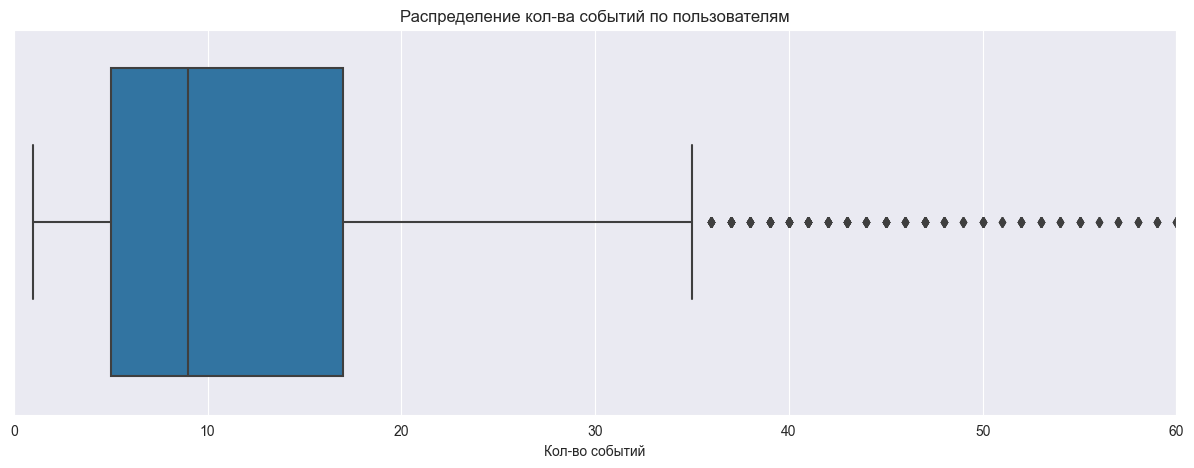

In [49]:
plt.figure(figsize = (15,5))
sns.boxplot(x='count_event', data=event_per_user)
plt.title('Распределение кол-ва событий по пользователям')
plt.xlabel("Кол-во событий")
plt.xlim(0,60); 

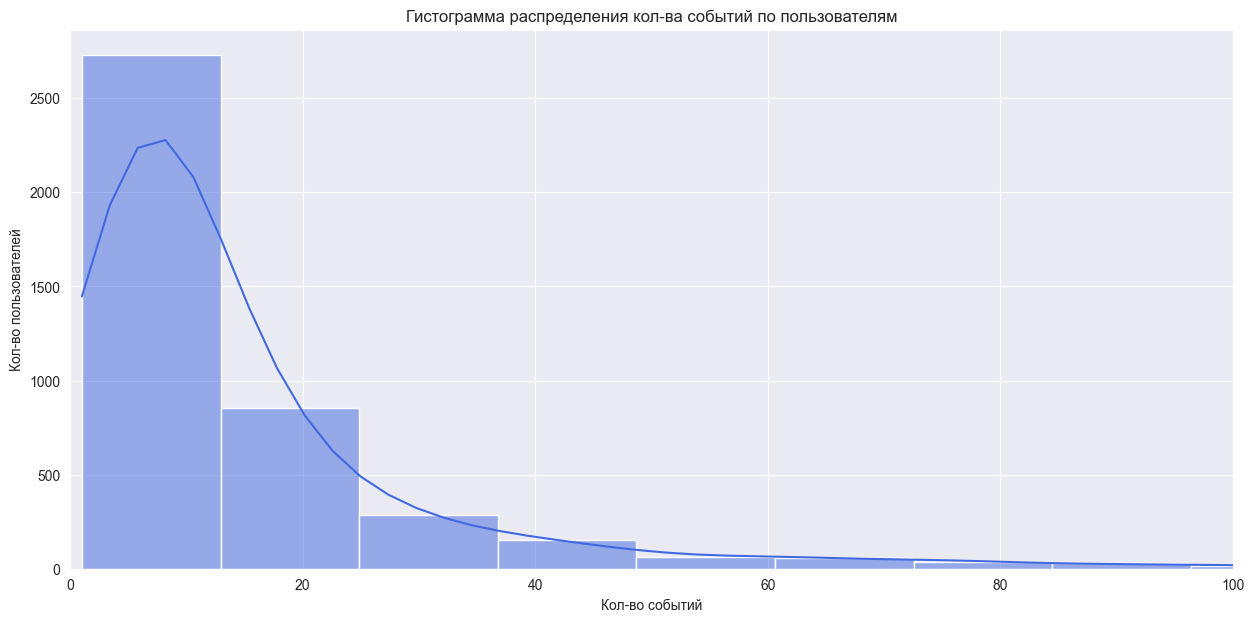

In [50]:
fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(x='count_event', data=event_per_user, kde=True, bins=40, ax=ax, color='royalblue') 
ax.set_xlim(0,100)
plt.title('Гистограмма распределения кол-ва событий по пользователям')
plt.ylabel("Кол-во пользователей")
plt.xlabel("Кол-во событий");

**Вывод:**

В среднем на каждого пользовател приходится по 17 событий, медианное значение составляет 9 событий. Наши данные скошены вправо - есть пользователи совершившие намного больше действий, чем средний пользователь.

95% пользователей совершили не более 59 действий.

#### Посмотрим кол-во действий в разрезе сессий

In [51]:
sessions.head(2)

,user_id,session_id,source,session_start,session_end,events_count,duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9,0 days 00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,4,0 days 00:08:27.385985


In [52]:
sessions['events_count'].describe(percentiles=[0.25, 0.5, 0.95, 0.99])

count    10368.000000
mean         7.156346
std          9.581106
min          1.000000
25%          2.000000
50%          4.000000
95%         24.000000
99%         47.000000
max        149.000000
Name: events_count, dtype: float64

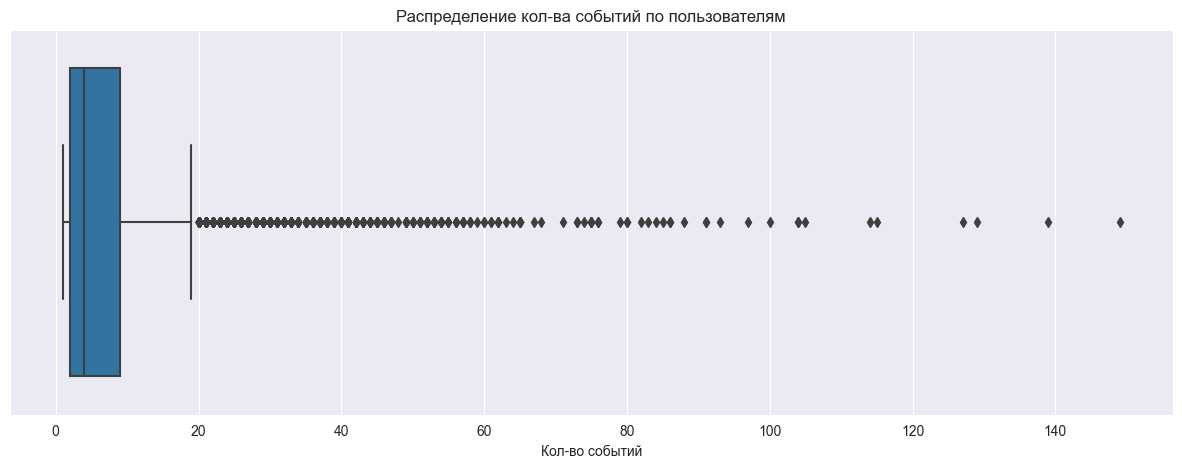

In [53]:
plt.figure(figsize = (15,5))
sns.boxplot(x='events_count', data=sessions)
plt.title('Распределение кол-ва событий по пользователям')
plt.xlabel("Кол-во событий"); 

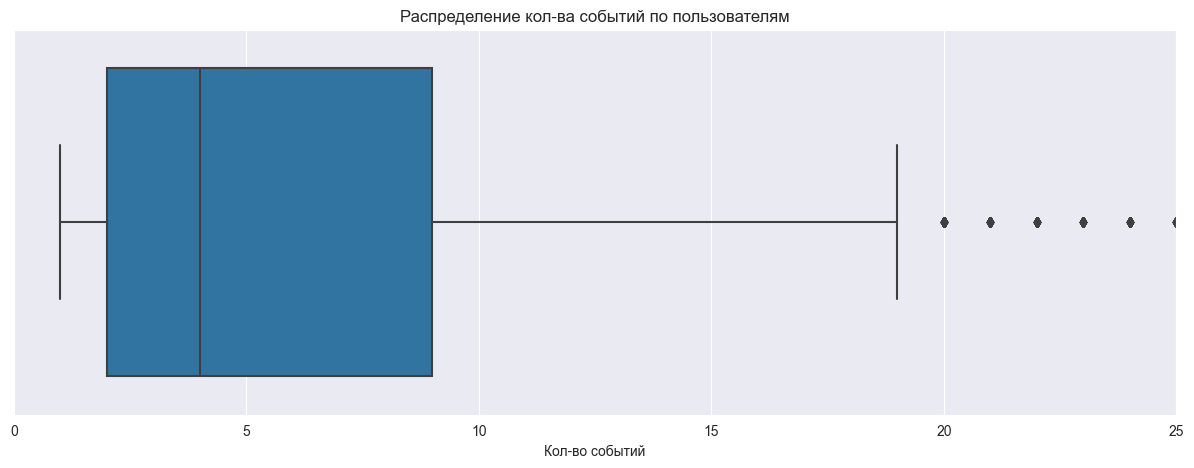

In [54]:
plt.figure(figsize = (15,5))
sns.boxplot(x='events_count', data=sessions)
plt.title('Распределение кол-ва событий по пользователям')
plt.xlabel("Кол-во событий")
plt.xlim(0,25); 

В среднем за каждую сесиию пользователь совершает 7 событий, медианное значение составляет 4 событий. Наши данные скошены вправо - есть пользователи совершившие намного больше действий, чем средний пользователь.

95% пользователей совершают за сессию до 25 действий\
А четверть наших пользователей совершили не более 2х действий

<a id='one'></a>

#### Анализ пользователей, совершивших всего 1 сессию с 1 событием 

In [55]:
print('Кол-во пользователей, совершивщих 1 сессию с 1 событием',
      sessions.query('session_id == 1 & events_count == 1')['user_id'].nunique()
     )

Кол-во пользователей, совершивщих 1 сессию с 1 событием 441


In [56]:
# собираем id пользователей
user_1 = list(sessions.query('session_id == 1 & events_count == 1')['user_id'])
one_action_event = (data.query('user_id in @user_1')
     .groupby('event_name', as_index=False)['event_time']
     .count().sort_values(by='event_time', ascending=False)
)
one_action_event

,event_name,event_time
8,tips_show,2334
4,photos_show,1329
5,search,691
6,show_contacts,405
0,advert_open,243
3,map,188
2,favorites_add,162
1,contacts_call,67
7,tips_click,58


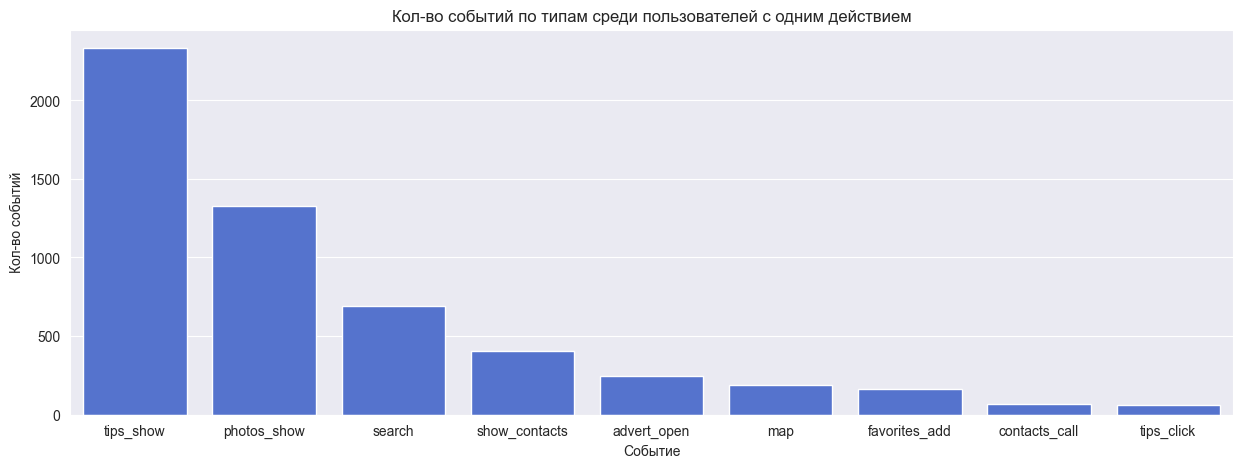

In [57]:
plt.figure(figsize=(15, 5))
sns.barplot(x='event_name', y='event_time', data=one_action_event, color='royalblue') 
plt.title('Кол-во событий по типам среди пользователей с одним действием')
plt.ylabel("Кол-во событий")
plt.xlabel("Событие");

Рассматрива пользователей совершивших всего одно действие в приложении видим, что самое популярное событие - tips_show, что означает пользователь увидел рекомендованные объявления. В то же время tips_click (клик по рекомендованному объявлению) имеет самый низкий показатель.
Можно предположить, что система рекомендаций работает не очень хорошо.

Однако не совсем понятно, как единсвтенным действием может быть например просмотр фото или контакта без действия advert_open — открытие карточки объявления

### Анализ пользователей по времени, проведённом в приложении

In [58]:
sessions['duration'].describe(percentiles=[0.25, 0.5, 0.90, 0.95, 0.99])

count                        10368
mean     0 days 00:12:52.672627050
std      0 days 00:19:51.611332472
min                0 days 00:00:00
25%      0 days 00:00:21.137141500
50%      0 days 00:05:35.169711500
90%      0 days 00:34:13.914407300
95%      0 days 00:48:31.391013050
99%      0 days 01:32:17.994593350
max         0 days 05:21:58.296302
Name: duration, dtype: object

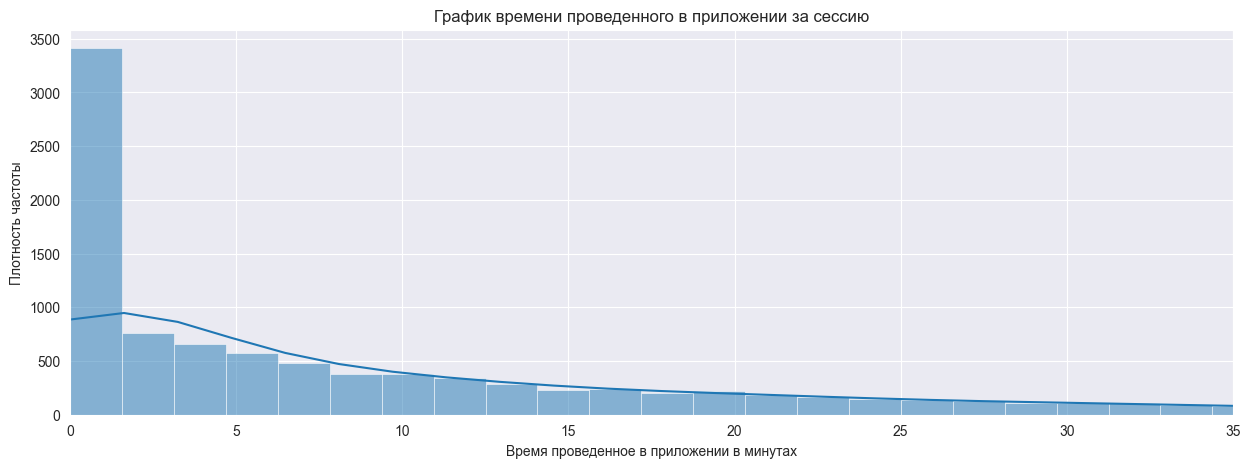

In [59]:
plt.figure(figsize=(15, 5))
sns.histplot(sessions['duration'].apply(lambda x: x.total_seconds()) /60 , kde=True)
plt.title('График времени проведенного в приложении за сессию')
plt.ylabel("Плотность частоты")
plt.xlabel("Время проведенное в приложении в минутах")
plt.xlim(0,35)
plt.show()

Медиана длительности одной сесии составляет 5,5 минут. Среднее - почти 13 минут.
90% сессий длятся менее 35 минут

In [60]:
duration_session = sessions.groupby('user_id').agg({'duration':'sum', 'session_id':'last'}).reset_index()
duration_session.sort_values(by='duration', ascending=False).head(5)

,user_id,duration,session_id
3397,cb36854f-570a-41f4-baa8-36680b396370,1 days 04:04:45.608271,50
3162,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,0 days 19:07:25.528439,36
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,0 days 17:25:30.426164,99
3794,e13f9f32-7ae3-4204-8d60-898db040bcfc,0 days 16:27:56.499025,38
3826,e38cb669-7335-4d56-9de5-c8d5d2f13fd3,0 days 15:00:29.129216,26


In [61]:
duration_session.describe(percentiles=[0.25, 0.5, 0.90, 0.95, 0.99])

,duration,session_id
count,4293,4293.000000
mean,0 days 00:31:06.077287970,2.415094
std,0 days 01:02:45.814535224,3.536466
min,0 days 00:00:00,1.000000
25%,0 days 00:06:04.048675,1.000000
50%,0 days 00:15:05.737061,1.000000
90%,0 days 01:06:01.298116200,4.000000
95%,0 days 01:52:11.384636199,7.000000
99%,0 days 04:12:44.356512039,17.000000
max,1 days 04:04:45.608271,99.000000


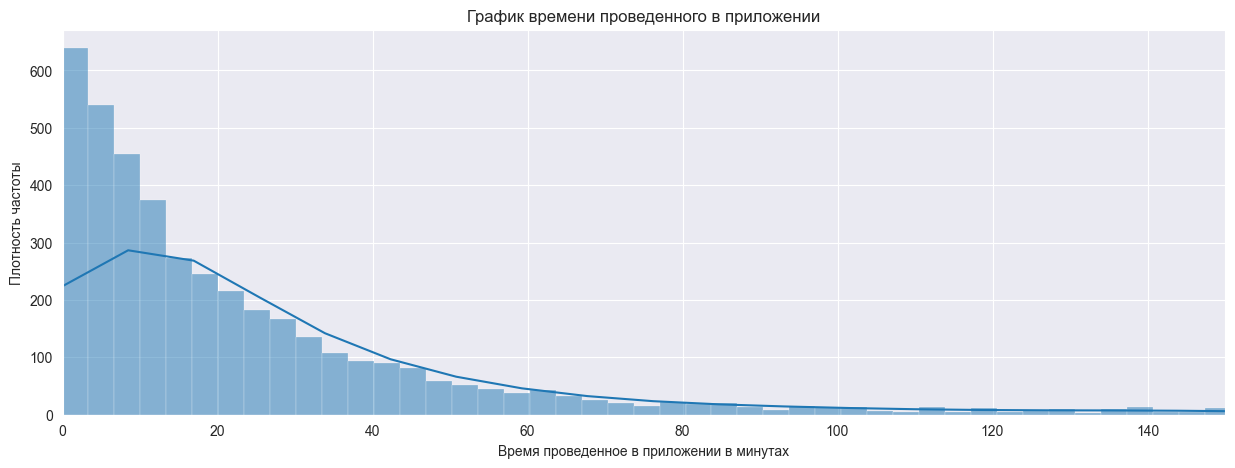

In [62]:
minutes = duration_session['duration'].apply(lambda x: x.total_seconds()) /60

plt.figure(figsize=(15, 5))
sns.histplot(minutes, kde=True)
plt.title('График времени проведенного в приложении')
plt.ylabel("Плотность частоты")
plt.xlabel("Время проведенное в приложении в минутах")
plt.xlim(0,150)
plt.show()

Медианное время всех сессий имещихся пользователей составляет 15 минут. Среднее - 31 минуту (на него влияют долгие сессии отдельных пользователей)
90% пользователей провели в приложении менее чем 1 час и 6 минут за все сессии. 

In [63]:
sessions.head()

,user_id,session_id,source,session_start,session_end,events_count,duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9,0 days 00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,4,0 days 00:08:27.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,14,0 days 00:14:59.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,8,0 days 00:12:38.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,9,0 days 00:25:20.787329


### Анализ пользователей по активности по дням недели

In [64]:
data.head()

,event_time,event_name,user_id,date,event_weekday,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1


In [65]:
event_weekday = data.groupby('event_weekday')['event_time'].count().reset_index()
event_weekday

,event_weekday,event_time
0,0,11671
1,1,11145
2,2,10995
3,3,10762
4,4,9969
5,5,9154
6,6,10501


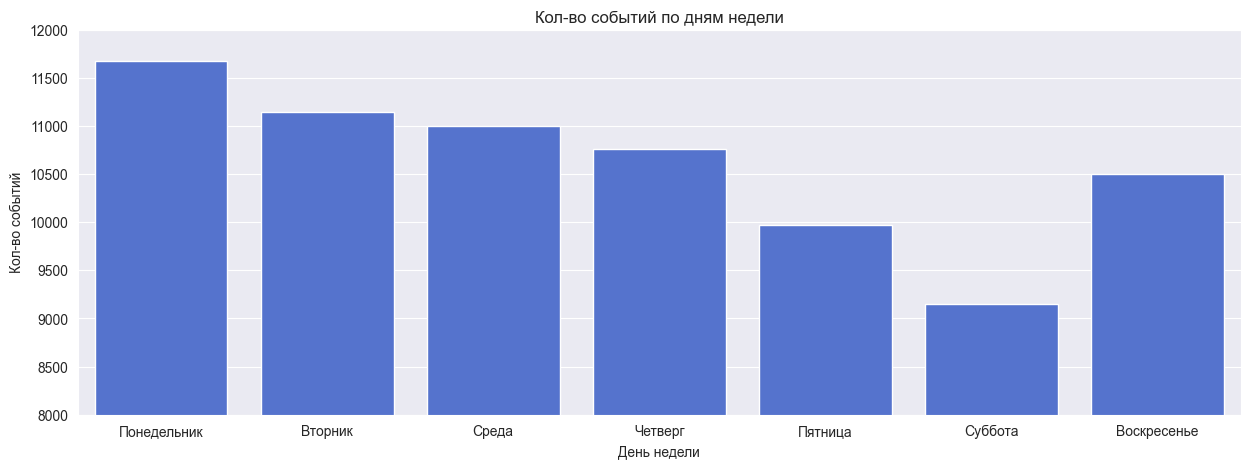

In [66]:
plt.figure(figsize=(15, 5))

name_day = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
sns.barplot(x=name_day, y='event_time', data=event_weekday, color='royalblue') 
plt.title('Кол-во событий по дням недели')
plt.ylabel("Кол-во событий")
plt.xlabel("День недели")
plt.ylim(8000,12000);

Меньше всего действий наши пользователи совершили в субботу и пятницу. Возможно в эти дни люди отдыхают и не хотят заниматься куплей-продажей. А вот в понедельник активность самая высокая.

In [67]:
weekday_contact = data.query('event_name == "show_contacts"').groupby('event_weekday', as_index=False)['event_time'].count()
weekday_contact.columns = ['event_weekday', 'count_action']
weekday_contact

,event_weekday,count_action
0,0,646
1,1,708
2,2,715
3,3,825
4,4,665
5,5,447
6,6,523


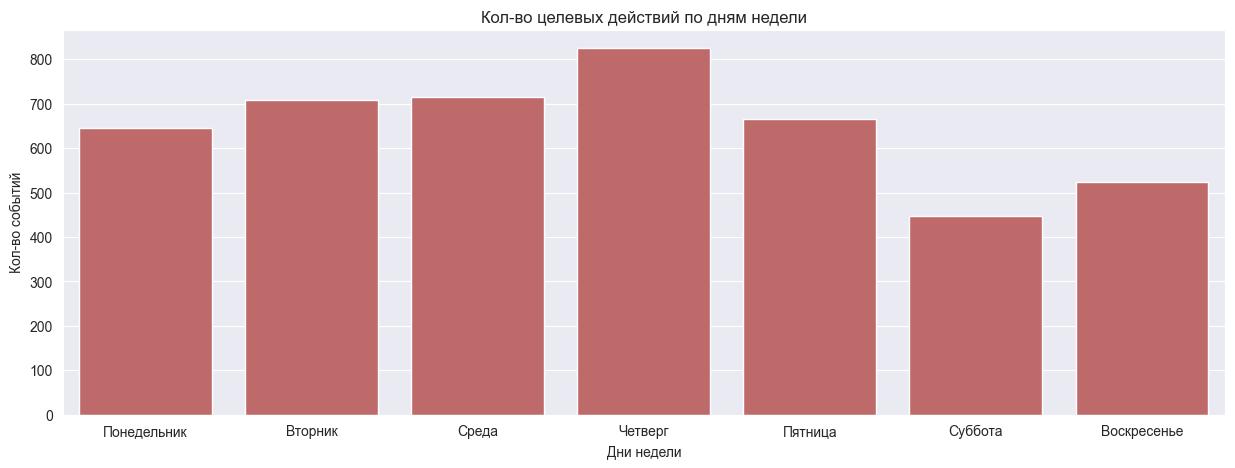

In [68]:
plt.figure(figsize=(15, 5))

sns.barplot(x=name_day, y='count_action', data=weekday_contact, color='indianred') 
plt.title('Кол-во целевых действий по дням недели')
plt.ylabel("Кол-во событий")
plt.xlabel("Дни недели");

Чаще всего целевое действие совершали в четверг, реже всего в субботу и воскресенье

### Анализ пользователей по retention rate

Из ТЗ: *В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.*\
Значит время первой сессии в датасете будет в принципе первой сессией пользователя. 
Сформируем пользовательские профили с датой первой сессии

In [69]:
# функция для создания профилей
def get_profiles(sessions):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения session_start
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'source': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date

    return profiles

In [70]:
profiles = get_profiles(sessions)
profiles.head()

,user_id,first_ts,source,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25


In [71]:
sessions.head()

,user_id,session_id,source,session_start,session_end,events_count,duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,other,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9,0 days 00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,other,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,4,0 days 00:08:27.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,other,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,14,0 days 00:14:59.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,other,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,8,0 days 00:12:38.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,1,yandex,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,9,0 days 00:25:20.787329


In [72]:
# функция для удержания по всем пользователям
def get_retention_all(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Зададим горизонт анализа в 2 недели и посмотрим удержание пользователей успевших прожить это время на момент максимальной даты в данных

In [73]:
observation_date = event.date.max()
horizon_days = 14

In [74]:
# применяем функцию
retention_raw, retention_grouped = (
    get_retention_all(profiles, sessions, observation_date, horizon_days)
)

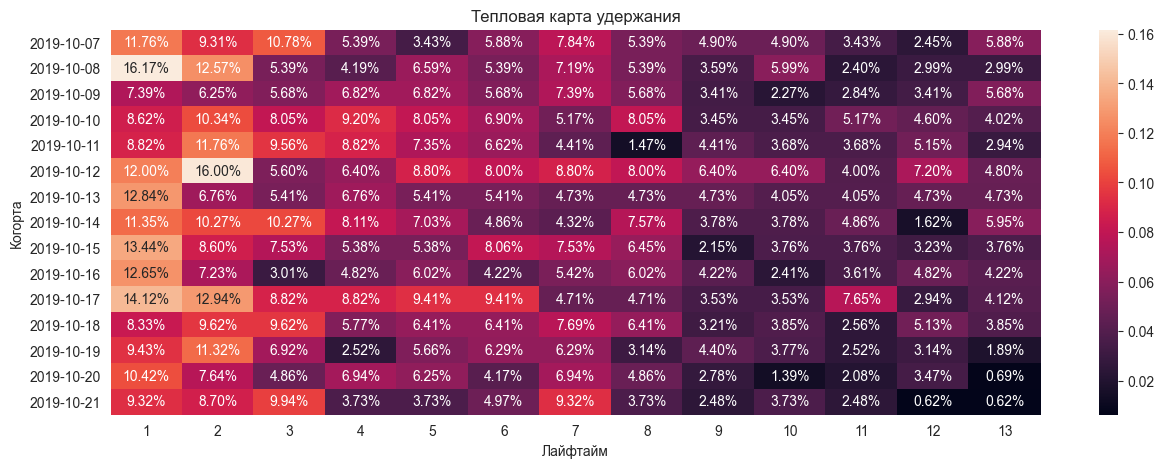

In [75]:
plt.figure(figsize=(15, 5))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.ylabel("Когорта")
plt.xlabel("Лайфтайм");
plt.show() 

Удержание второго для от когорты к когорте составляет от 7,4 до 16%. Лучше всего себя показывают пользователи пришедшие 8 и 12 октября - у них самое высокое удержание на второй и третий день - около 16%

К концу второй недели удержание не превышает 6%


### Анализ пользователей по конверсии в целевое действие — просмотр контактов

Целевым действием будем считать show_contacts (просмотр контакта), а не contacts_call (звонок), т.к. не все пользователи звонят через внутреннее приложение, либо могли записать контакт и позвонть позже.

Так же в нашем приложении нет четко выстроенной воронки - пользователи могут выполнять различные действия в любом порядке перед тем, как посмотреть контакт.
Посчитаем общую конверсию в целевое действие

In [76]:
data.head(2)

,event_time,event_name,user_id,date,event_weekday,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1


In [77]:
# Число посетителей сайта
visitors = data['user_id'].nunique()
# Число людей, выполнивших определенное действие
conversions = data[data['event_name'] == 'show_contacts']['user_id'].nunique()

print('Общее число пользователей', visitors)
print('Кол-во пользователей совершивших целевое действие', conversions)

Общее число пользователей 4293
Кол-во пользователей совершивших целевое действие 981


In [78]:
# Рассчитываем конверсию
conversion_rate = (conversions / visitors) * 100
# Выводим результат
print(f'Общая конверсия составляет {conversion_rate:.2f}%')

Общая конверсия составляет 22.85%


Теперь посчитаеем конверсию с учетом горизонта анализа. И посмотрим как она меняется во времени

In [79]:
#  Функция для расчета конверсии с учетом горизонта анализа
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_time']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [80]:
target_users = data.query('event_name == "show_contacts"')
target_users.head(3)

,event_time,event_name,user_id,date,event_weekday,source,session_id
33533,2019-10-20 19:17:18.659799,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,6,yandex,2
33544,2019-10-20 19:23:11.839947,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,6,yandex,2
33565,2019-10-20 19:30:31.912891,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,6,yandex,2


In [81]:
observation_date = event.date.max()
horizon_days = 14

In [82]:
raw_conv, conversion, result_in_time_conv = (
    get_conversion(profiles, target_users, observation_date, horizon_days)
)

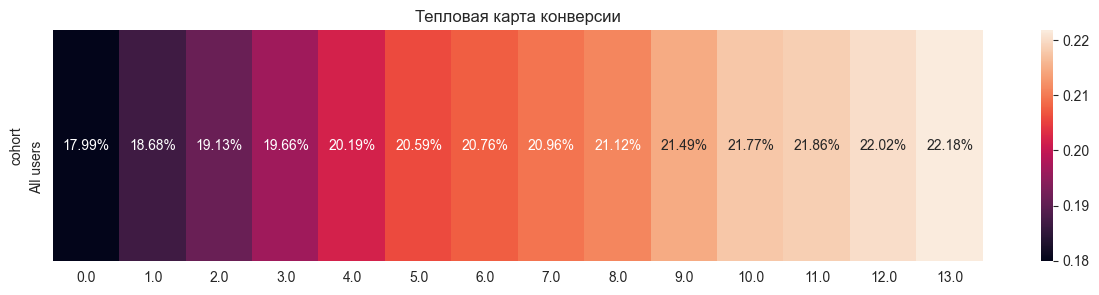

In [83]:
# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 3))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии')
plt.show() 

Конверсия в первые дни составляет около 18% и к концу второй недели достигает 22,18% 

### Вывод по исследовательскому анализу

По итогам исследовательского анализа можем сказать:
- Средний пользователь совершает 9 действий за весь исследуемый период и 4 за каждую свою сессию. 
- Его сессия длится 5,5 минут и общее время в приложении составляет около 15 минут
- Самая высокая активность в понедельник. Целевое действие чаще всего совершается в четверг
- Конверсия по всем пользователям в целевое действие составляет 18% в первые дни и к концу второй недели достигает 22,18%
- Удержание второго для от когорты к когорте составляет от 7,4 до 16%. К концу второй недели удержание не превышает 6%

## Сегментация пользователей

### Разделение пользователей по источнику привлечения

В первую очередь посмотрим на пользователей в разрезе истоника привлечения. Как минимум эта информация у нас есть и ей можно воспользоваться. К тому же, если пользователи из одного источника удерживаются и конвертируются лучше, чем из другого - можно посоветовать отделу маркетинга сместить фокус по привлечению именно на этот источник, а не тратить ресурсы на источники приносящие менее качественных пользователей.

#### Пользователи какой группы по источнику склонны часто возвращаться в мобильное приложение (retention rate)

In [84]:
# функция  для расчета удержания с учетом группы
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],  # параметр для группировки таблицы удержания
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

Для начала посмотрим удержание пользователей в зависимости от источника привлечения

In [85]:
dimensions = ['source']

In [86]:
result_raw, retention = get_retention(profiles, sessions, observation_date, horizon_days, dimensions= dimensions)

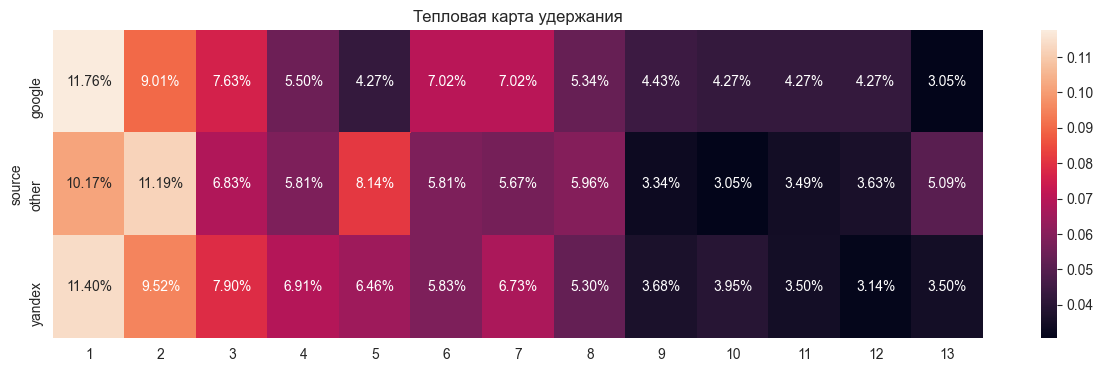

In [87]:
plt.figure(figsize=(15, 4))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show() 

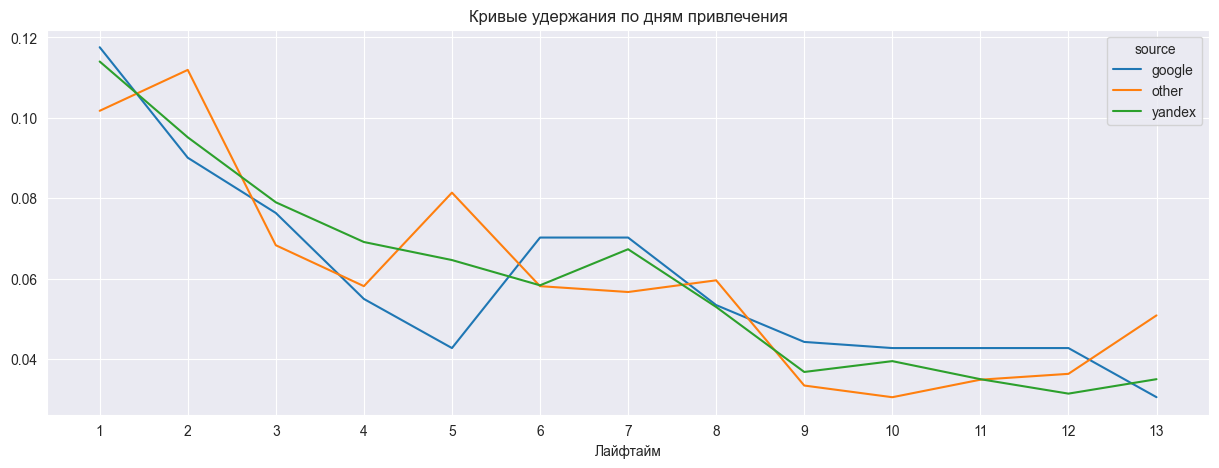

In [88]:
report = retention.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

Среди источников нет явного лидера по качеству удержания. 

#### Пользователи какой группы по источнику часто делают целевое событие (конверсия в целевое действие)

In [89]:
observation_date = event.date.max()
horizon_days = 14
dimensions = ['source']

In [90]:
raw_conv, result_grouped_conv, result_in_time_conv = (
    get_conversion(profiles, target_users, observation_date, horizon_days, dimensions=dimensions)
)

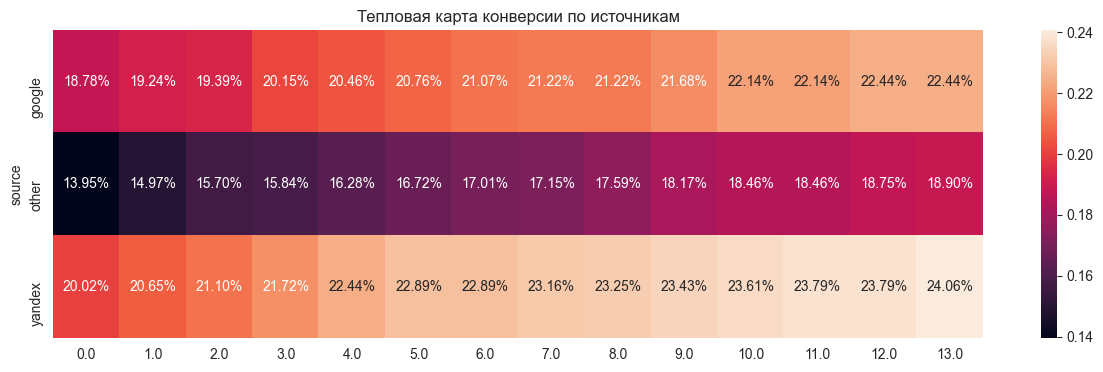

In [91]:
# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 4))
sns.heatmap(result_grouped_conv.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по источникам')
plt.show() 

Конверсия у пользователей, привлеченных с других источников явно ниже, чем с яндекс или гугл. 
На 14 день лучшую конверсию показывают пользователи из яндекса - 24%

### Кластеризация с помощью ML

Попробуем разделить аудиторию принципами машинного обучения. 
Выполним кластеризацию - сегментацию клиентов на основании схожести по определенным признакам между ними.

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [93]:
# преобразуем категориальное поле event_name в множество бинарных полей
ml_data = pd.get_dummies(data['event_name'])
#присоединяем id пользователей
ml_data = data[['user_id']].join(ml_data)
# удаляем столбец contacts_call, т.к. он точно следует за просмотром контакта (нашим целевым действием)
ml_data = ml_data.drop('contacts_call', axis=1)
ml_data.head()

,user_id,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show
805,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,0,0,0,1
806,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,0,0,0,1
809,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,0,0,0,1
820,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,0,0,0,1
830,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,0,0,0,1


In [94]:
# Считаем кол-во каждых событий для каждого пользователя
ml_data = ml_data.groupby('user_id', as_index=False).sum()
ml_data.head()

,user_id,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,6.0,0.0,0.0,0.0,0.0,29.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.0,2.0,0.0,33.0,18.0,11.0,0.0,0.0
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,0.0,6.0,0.0,17.0,0.0,0.0,4.0
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0


In [ ]:
#ml_data['show_contacts'] = np.where(ml_data['show_contacts'] > 0, 'True','False')

In [ ]:
#ml_data.head()

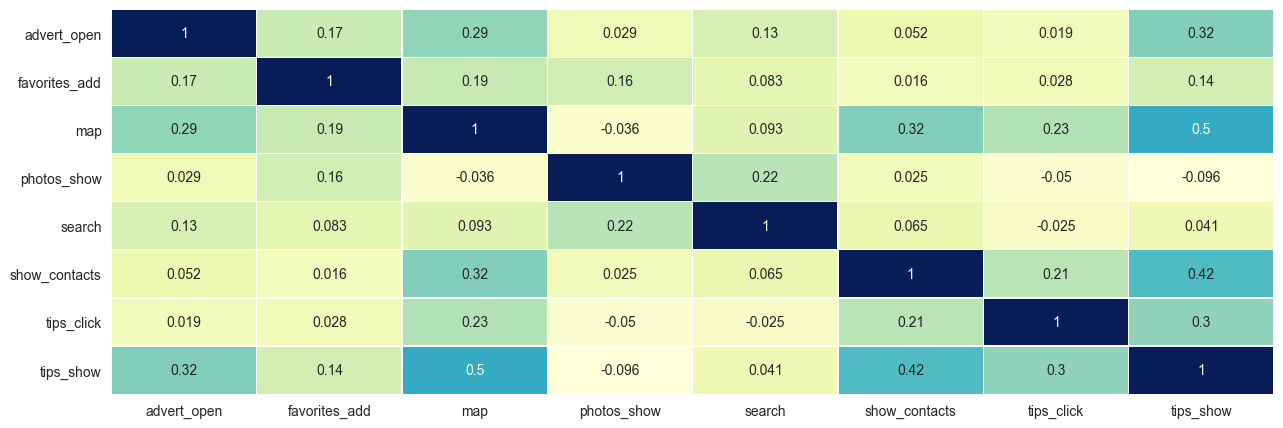

In [95]:
# матрица корреляций
plt.figure(figsize=(15, 5))
sns.heatmap(ml_data.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

Сильно коррелирующих признаков между собой нет

In [96]:
ml_data.head()

,user_id,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,6.0,0.0,0.0,0.0,0.0,29.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.0,2.0,0.0,33.0,18.0,11.0,0.0,0.0
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,0.0,6.0,0.0,17.0,0.0,0.0,4.0
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0


Для более корректной работы алгоритма избавимя от аномальных значений в данных

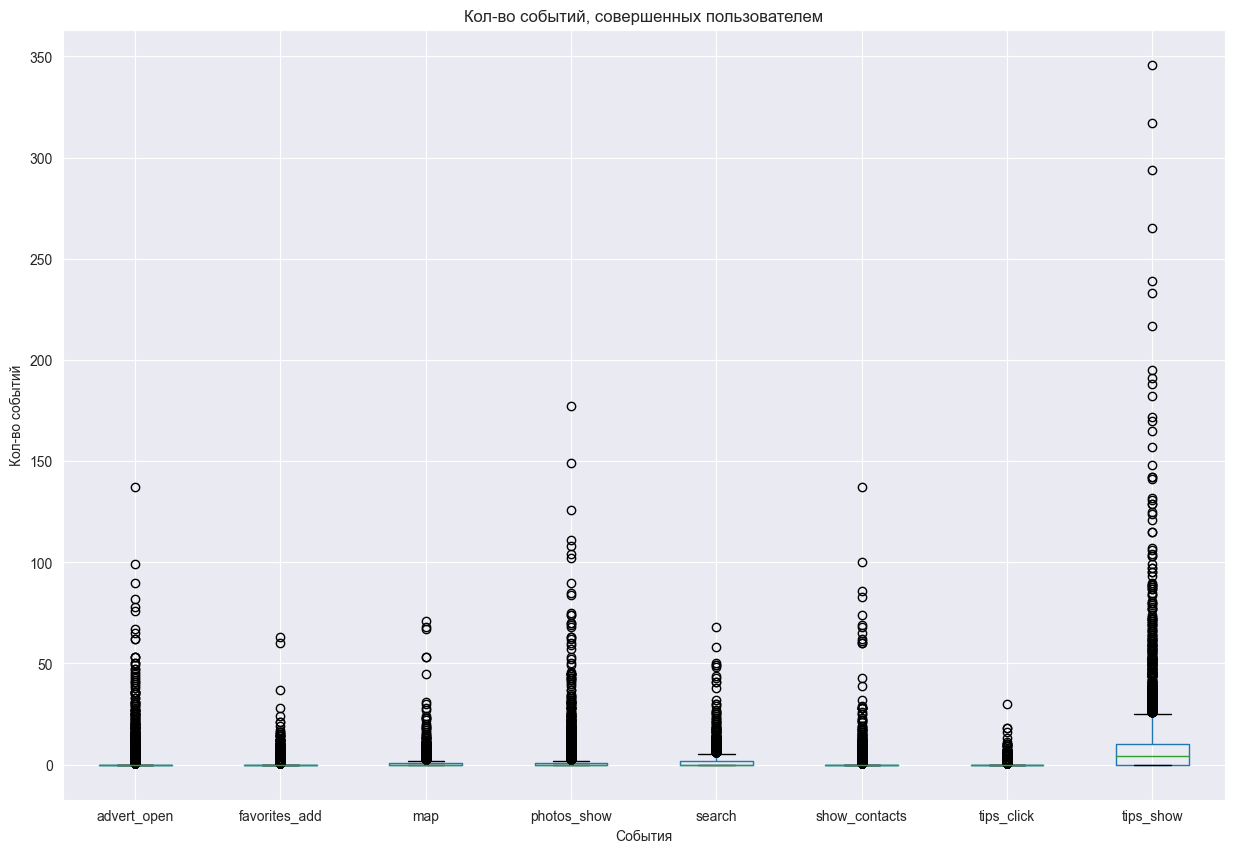

In [97]:
plt.figure(figsize=(15, 10))
ml_data.boxplot()
plt.title('Кол-во событий, совершенных пользователем')
plt.ylabel("Кол-во событий")
plt.xlabel("События");

In [98]:
ml_data.describe(percentiles=[0.25, 0.5, 0.90, 0.95, 0.99])

,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,1.435826,0.330072,0.904030,2.332169,1.580247,1.054973,0.189611,9.330305
std,6.156880,2.109938,3.040441,8.386409,3.778452,4.989622,1.044630,19.877676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
90%,3.000000,0.000000,2.000000,6.000000,4.000000,2.000000,0.000000,23.000000
95%,7.000000,1.000000,4.000000,11.000000,6.000000,5.000000,1.000000,37.000000
99%,29.000000,9.000000,10.000000,37.000000,16.080000,15.000000,4.000000,88.080000
max,137.000000,63.000000,71.000000,177.000000,68.000000,137.000000,30.000000,346.000000


In [99]:
ml_data.shape

(4293, 9)

Установим порог, при котором наблюдение считается выбросом. Отбросим 3% самых больших значений

In [100]:
# Считаем 95-й перцентиль для каждого столбца
percentiles = ml_data.drop(['user_id', 'show_contacts'], axis=1).quantile(0.97)

# Удаляем значения, превышающие 95-й перцентиль
ml_data[ml_data.drop(['user_id', 'show_contacts'], axis=1) > percentiles] = np.nan
# Удаляем строки в которых теперь появились пропуски
ml_data = ml_data.dropna()

In [101]:
ml_data = ml_data.dropna()
ml_data.shape

(3677, 9)

In [102]:
ml_data.head()

,user_id,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
5,00554293-7e00-4122-b898-4e892c4a7c53,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0
6,005fbea5-2678-406f-88a6-fbe9787e2268,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0
7,00653802-5ff1-4071-bc17-347fc4cef569,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [103]:
# выделяем целевую переменную и признаки
y = ml_data['show_contacts']
X = ml_data.drop(['show_contacts', 'user_id'], axis=1) 

# выполняем стандартизацию признаков
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [104]:
km = KMeans(n_clusters=2, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [105]:
# оценим метрику силуаэта для кластеризации 
silhouette_score(X_sc, labels)

0.22571173657525084

Метрика силуэта показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой.
Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.

В нашем случае значение получилось чуть выше среднего.

In [106]:
# добавляем столбец с номером кластера в таблицу
ml_data['cluster'] = labels
ml_data.head()

,user_id,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show,cluster
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,1
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1
5,00554293-7e00-4122-b898-4e892c4a7c53,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0
6,005fbea5-2678-406f-88a6-fbe9787e2268,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0
7,00653802-5ff1-4071-bc17-347fc4cef569,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1


In [107]:
# смотрим на сколько одинаковые по размеру получились кластеры
ml_data.groupby('cluster', as_index=False)['user_id'].count()

,cluster,user_id
0,0,2409
1,1,1268


In [108]:
ml_data.groupby('cluster').mean()

,advert_open,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show
cluster,,,,,,,,
0,0.769614,0.016604,0.815691,0.016189,0.425903,0.733914,0.095060,9.160648
1,0.082019,0.161672,0.041009,3.700315,2.393533,0.675079,0.006309,0.873817


Не смотря на средние показатели оценки модели, можно выделить характерные признаки для наших кластеров:

В кластере 0 пользователи:
- Смотрят больше карточек
- Смотрят карту размещения
- Смотрят рекомендованные объявления
- Чаще кликают по рекомендованным объявлениям

В кластере 1 пользователи:
- Смотрят фотографии
- Ищут по сайту самостоятельно 
- Чаще добавляют в избранное

In [109]:
# добавляем в профили информацию о кластере
profiles = profiles.merge(ml_data[['user_id', 'cluster']], on ='user_id', how = 'left')

#### Пользователи какого кластера склонны часто возвращаться в мобильное приложение (retention rate)

In [110]:
# задаем горизонт анализа
observation_date = event.date.max()
horizon_days = 14
dimensions = ['cluster']

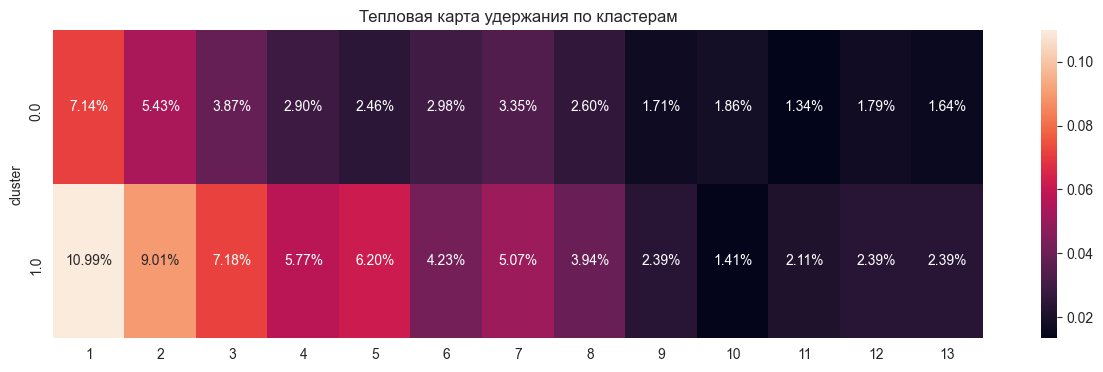

In [111]:
result_raw, result_grouped = get_retention(profiles, sessions, observation_date, horizon_days, dimensions= dimensions)
plt.figure(figsize=(15, 4))
sns.heatmap(result_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания по кластерам')
plt.show() 

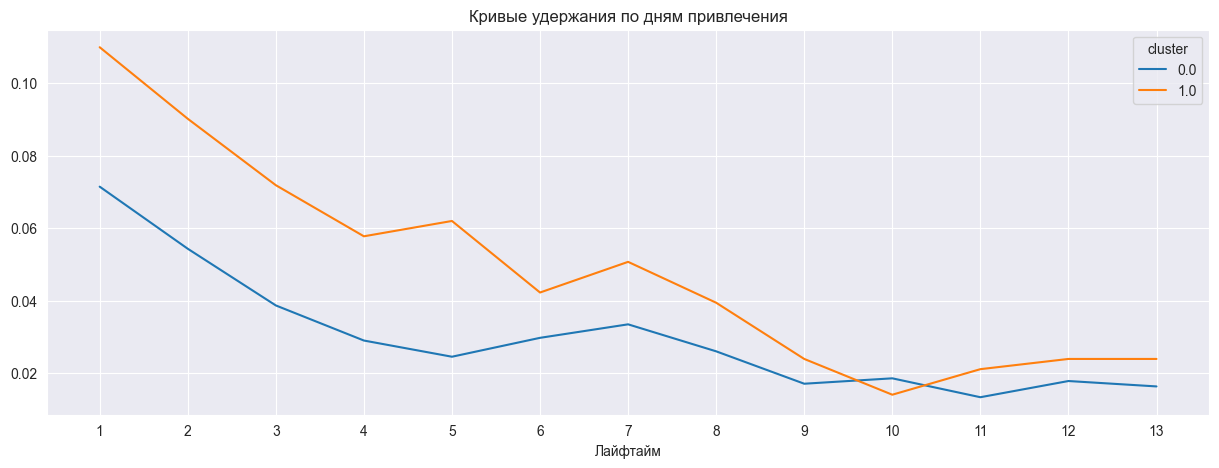

In [112]:
report = result_grouped.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

Кластер №1 показывает лучшее удержание, чем Кластер №0, особенно в первую неделю. 

#### Пользователи какого кластера часто делают целевое событие (конверсия в целевое действие)¶

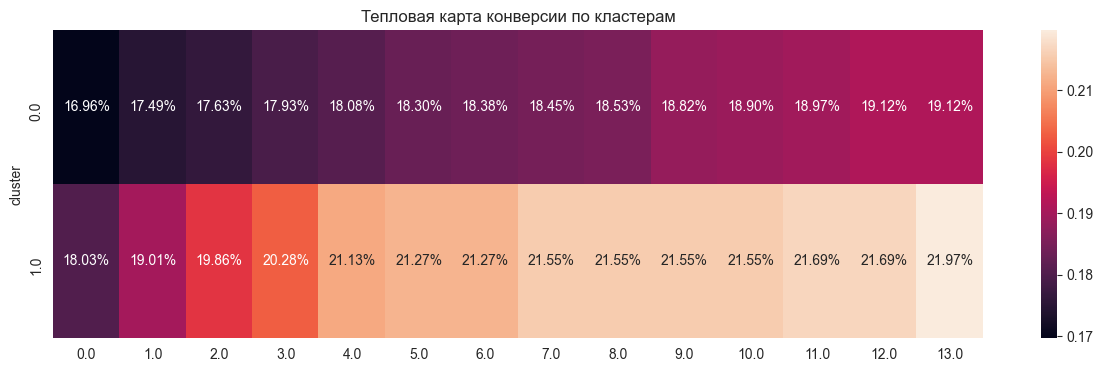

In [113]:
raw_conv, conversion, result_in_time_conv = (
    get_conversion(profiles, target_users, observation_date, horizon_days, dimensions=dimensions)
)
# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 4))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по кластерам')
plt.show() 

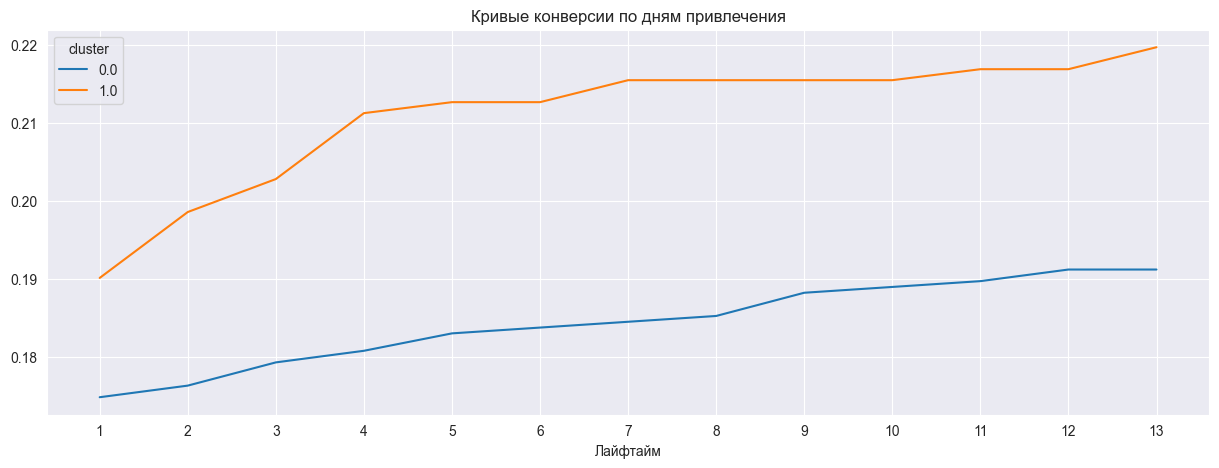

In [114]:
report = conversion.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые конверсии по дням привлечения')  # название графика
plt.show()

Конверсия Класера №1 заметно лучше, чем Кластера №0

### Вывод

1. По итогам сегментирования пользователей по источнику:

Источник привлечения практические не влияет на удержание пользователей, а вот конверсия у пользователей, привлеченных с других источников явно ниже, чем с яндекс или гугл. 
    На 14 день лучшую конверсию показывают пользователи из яндекса - 24% и Гугл - 22,4%\
**Далее проверим гипотезу есть статистически значимое различие в концерсии между лидирующими источниками - Яндекс и Гугл**


2. По итогам кластеризации:

    Пользователи из кластера №1, которые:
    - Смотрят фотографии
    - Ищут по сайту самостоятельно
    - Чаще добавляют в избранное
    
Показыевают лучшее удержание и заметно лучшую конверсию в целевое действие, чем пользователи из Кластера №0, где собраны пользователи которые:

    - Смотрят больше карточек
    - Смотрят карту размещения
    - Смотрят рекомендованные объявления
    - Чаще кликают по рекомендованным объявлениям

    (можно сказать больше смотрят предложенные объявления)
    
Проанализировав Кластер №1:
Мы не можем повлиять на поиск и заставить пользователей смотреть больше фотографий, но можем например сделать более удобное добавление в избранное и напоминание это делать (чтобы не терять интересные предложения).\
**Исходя из этого проверим гипотезу, что добавление в избранное повышает конверсию**

## Проверка гипотез

### Гипотеза о конверсии в зависимости от источника

**Нулевая гипотеза:** Пользователи пришедшие из yandex и пользователи из google демонстрируют одинаковую конверсию в целевое действие (промотр контактов)\
**Альтернативная гипотеза:** Пользователи пришедшие из yandex и пользователи из google демонстрируют разную конверсию в целевое действие (промотр контактов)

In [115]:
data.head(2)

,event_time,event_name,user_id,date,event_weekday,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1


In [116]:
visitors_yandex = data.query('source == "yandex"')['user_id'].nunique()
print('Общее число пользователей из яндекс', visitors_yandex)
visitors_google = data.query('source == "google"')['user_id'].nunique()
print('Общее число пользователей из google', visitors_google)

Общее число пользователей из яндекс 1934
Общее число пользователей из google 1129


In [117]:
successes_yandex = data.query('source == "yandex" & event_name == "show_contacts"')['user_id'].nunique()
print('Число пользователей совершивщих действие из яндекс', successes_yandex)
successes_google = data.query('source == "google" & event_name == "show_contacts"')['user_id'].nunique()
print('Число пользователей совершивщих действие из гугл', successes_google)

Число пользователей совершивщих действие из яндекс 478
Число пользователей совершивщих действие из гугл 275


In [118]:
print(f'Конверсия пользователей из Яндекс {successes_yandex/visitors_yandex:.3%}') 
print(f'Конверсия пользователей из Гугл {successes_google/visitors_google:.3%}')

Конверсия пользователей из Яндекс 24.716%
Конверсия пользователей из Гугл 24.358%


Конверсия пользователей из Яндекс лучше на 0,4%. Не очень большая разница. Для подтверждении предположения проведем статистический тест

In [119]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([successes_yandex, successes_google])
trials = np.array([visitors_yandex, visitors_google])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 


p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-value = 0,82 - вероятность ошибиться, признав выборки отличающимися больше, чем мы можем себе позволить.
С высокой вероятностью между пользователями, установившими приложение из разных источников, нет значимой разницы. Можно сделать вывод, что источник установки на конверсию не влияет.

### Гипотеза о конверсии в зависимости от добавления в избранное

**Нулевая гипотеза:** Пользователи добавившие объявления в избранное и пользователи не совершившие это действие показывают одинаковую конверсию\
**Альтернативная гипотеза:** Пользователи добавившие объявления в избранное показывают конверсию выше, чем пользователи не совершившие это действие

In [120]:
data.head()

,event_time,event_name,user_id,date,event_weekday,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,other,1


In [121]:
favorite = data.query('event_name == "favorites_add"')['user_id'].nunique()
print('Число пользователей добавивших объявление в избранное', favorite)

# собираем id тех, кто добавлял в избранное
favorite_id = data.query('event_name == "favorites_add"')['user_id'].unique()

not_favorite = data.query('user_id not in @favorite_id')['user_id'].nunique()
print('Число пользователей не добавших объявление в избранное', not_favorite)

Число пользователей добавивших объявление в избранное 351
Число пользователей не добавших объявление в избранное 3942


In [122]:
successes_favorite = data.query('user_id in @favorite_id & event_name == "show_contacts"')['user_id'].nunique()
print('Число пользователей совершивщих действие имея объявление в избранном', successes_favorite)

successes_not_favorite = data.query('user_id not in @favorite_id & event_name == "show_contacts"')['user_id'].nunique()
print('Число пользователей совершивщих действие не имея избранных', successes_not_favorite)

Число пользователей совершивщих действие имея объявление в избранном 136
Число пользователей совершивщих действие не имея избранных 845


In [123]:
print(f'Конверсия после добавления в избранное {successes_favorite/favorite:.3%}') 
print(f'Конверсия без добавления в избранное {successes_not_favorite/not_favorite:.3%}')

Конверсия после добавления в избранное 38.746%
Конверсия без добавления в избранное 21.436%


In [124]:
x = [0.3874, 0.2143]
y = ['После добавления в избранное', 'Без добавления в избранное ']

C:\Users\Vaida\AppData\Local\Temp\ipykernel_19592\1638245265.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])


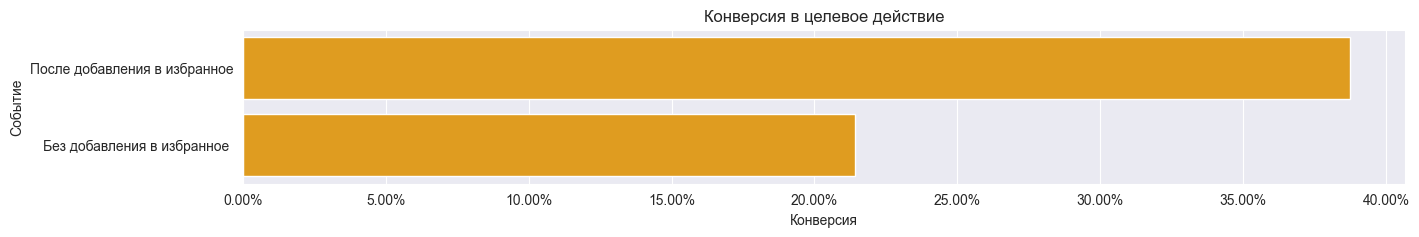

In [125]:
plt.figure(figsize=(15, 2))

ax = sns.barplot(x=x, y=y, color='orange') 
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.title('Конверсия в целевое действие')
plt.ylabel("Событие")
plt.xlabel("Конверсия");

Получаем, что конверсия после добавления в избранное лучше на 17%, что довольно много. Теперь проверим эти данные на статистически значимое различие. 

In [126]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([successes_favorite, successes_not_favorite])
trials = np.array([favorite, not_favorite])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

print(successes[0], successes[1], trials[0], trials[1])

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

136 845 351 3942
p-значение:  1.3455903058456897e-13
Отвергаем нулевую гипотезу: между долями есть значимая разница


По итогам теста получаем, что такая разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии.

## Общий вывод и рекомендации

На анализ предоставлен датасет с данными пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.
В нашем распоряжении данные за 27 дней - с 7.10.2019 по 3.11.2019
За имеющийся период имеем 4 293 уникальных пользователя, которые совершили 74 197 событий

**По итогам исследовательского анализа:**

- Чаще всего пользователи совершали не более 3 сессий. Большинство пользвателей ограничились одной сессией


- Изучили количество совершенных действий:
    - В среднем на каждого пользовател приходится по 17 событий, медианное значение составляет 9 событий. 95% пользователей совершили не более 59 действий.
    - В среднем за каждую сесиию пользователь совершает 7 событий, медианное значение составляет 4 событий. 95% пользователей совершают за сессию не более 25 действий. А четверть наших пользователей совершили не более 2х действий
    
    
- Рассматрев пользователей, совершивших всего одно действие в приложении видим, что самое популярное событие - tips_show, что означает пользователь увидел рекомендованные объявления. В то же время tips_click (клик по рекомендованному объявлению) имеет самый низкий показатель. Можно предположить, что система рекомендаций работает не очень хорошо.


- Изучили продоожительность времени в приложении:
    - Медиана длительности одной сесии составляет 5,5 минут. Среднее - почти 13 минут. 90% сессий длятся менее 35 минут
    - Среднее время всех сессий пользователей составляет 15 минут. Среднее - 31 минуту (на него влияют долгие сессии отдельных пользователей) 90% пользователей провели в приложении менее чем 1 час и 6 минут за все сессии.


- Изучили влияние дня недели на активность пользователей:
    - Меньше всего действий наши пользователи совершили в субботу и пятницу. Возможно в эти дни люди отдыхают и не хотят заниматься куплей-продажей. А вот в понедельник активность самая высокая.
    - Чаще всего целевое действие совершали в четверг, реже всего в субботу и воскресенье


**По итогам сегмаентации пользователей:**

1. Источник привлечения практические не влияет на удержание пользователей, а вот конверсия у пользователей, привлеченных с других источников явно ниже, чем с яндекс или гугл. На 14 день лучшую конверсию показывают пользователи из яндекса - 24%


2. По итогам кластеризации:
Пользователи из кластера №1, которые:

    - Смотрят фотографии
    - Ищут по сайту самостоятельно
    - Чаще добавляют в избранное
    
Показывают лучшее удержание и заметно лучшую конверсию в целевое действие, чем пользователи из Кластера №0, где собраны пользователи которые:

    - Смотрят больше карточек
    - Смотрят карту размещения
    - Смотрят рекомендованные объявления
    - Чаще кликают по рекомендованным объявлениям

(можно сказать больше смотрят предложенные объявления)

Опять же можно предположить, что система рекомендаций работает не лучшим образом. Люди ищущие сами по сайту и просматривающие фото с большей вероятностью находят, что им нужно


**По итогам проверки гипотез:**
- С высокой вероятностью между пользователями, установившими приложение из разных источников, нет значимой разницы. Можно сделать вывод, что источник установки на конверсию не влияет.

- Пользователи добавившие объявления в избранное показывают конверсию выше, чем пользователи не совершившие это действие.
    По итогам теста получили, что такая разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии.

**Рекомендации:**
- Было бы удобно добавить в данные отметку о принадлежности событий к определенной сессии. Это позволит более точно рассматривать пользовательские действия в разрезе сессий.

- Дополнительно проанализировать систему рекомендаций